In [1]:
import pandas as pd


We have created a df, that stores all the image paths and is sorted by label and split.
We first want to load that.

In [2]:
train_df = pd.read_csv('data/train/fer2013_train.csv')
test_df  = pd.read_csv('data/test/fer2013_test.csv')

train_df
test_df

,filepath,label,split
0,FER-2013\test\angry\PrivateTest_10131363.jpg,angry,test
1,FER-2013\test\angry\PrivateTest_10304478.jpg,angry,test
2,FER-2013\test\angry\PrivateTest_1054527.jpg,angry,test
3,FER-2013\test\angry\PrivateTest_10590091.jpg,angry,test
4,FER-2013\test\angry\PrivateTest_1109992.jpg,angry,test
...,...,...,...
7173,FER-2013\test\surprise\PublicTest_98089595.jpg,surprise,test
7174,FER-2013\test\surprise\PublicTest_98567249.jpg,surprise,test
7175,FER-2013\test\surprise\PublicTest_98972870.jpg,surprise,test
7176,FER-2013\test\surprise\PublicTest_99242645.jpg,surprise,test


It is good practice to add a third validation split when working with machine learning libraries. So that in the end when testing the model you get a totally unbiased test accuarcy. The validation split is used to finetune hyperparameters. It is ussually computed after each epoch. So first we will split our test data into test and validation set

In [3]:
from sklearn.model_selection import train_test_split

# stratify to keep the same class balance
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_df['filepath'], train_df['label'],
    test_size=0.1,  # e.g. 10% of training for validation
    stratify=train_df['label'],
    random_state=42
)

Next we want to encode our labels numerically. We will use the integers 0, ..., 6 and in the end use the softmax activation function to let the modell decide which class is the most likely.

In [4]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

#we transform the label categories to integers between 0 and 6
le = LabelEncoder().fit(train_labels)
train_y_int = le.transform(train_labels)          
val_y_int   = le.transform(val_labels) 


We will define a function that can read the iamges and format them into a 48*48*1 matrix with the last dimension being used for the label and 48*48 representing the picture in grayscale format. If we would have a color picture we could format it into 48*48*3*1 the third dimension being used for encoding blue green and red pixel values. It is also custom and good practice to normalite the pixel values to [0,1]

In [5]:
import cv2
import numpy as np

def load_and_preprocess(path, target_size=(48,48)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)     
    img = cv2.resize(img, target_size)
    #normalize
    img = img.astype('float32') / 255.0               
    return np.expand_dims(img, axis=-1)               


Next we want to prepare the dataset on which our training happens. tensorflow uses enables you to use so called generator function to allow us to create the numerical matrices we talked about before

In [6]:
import tensorflow as tf

def gen(paths, labels):
    for p, l in zip(paths, labels):
        img = load_and_preprocess(p)
        yield img, l

train_ds = tf.data.Dataset.from_generator(
    lambda: gen(train_paths, train_y_int),
    output_types=(tf.float32, tf.int32),
    output_shapes=([48,48,1], [])
)
train_ds = (train_ds
            .shuffle(1000)
            .batch(64)
            .prefetch(tf.data.experimental.AUTOTUNE))

val_ds = (tf.data.Dataset.from_generator(
            lambda: gen(val_paths,   val_y_int),
            output_types=(tf.float32, tf.int32),
            output_shapes=([48,48,1], [])
          )
          .batch(64)
          .prefetch(tf.data.experimental.AUTOTUNE))

for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)   
    print("Label batch shape:", labels.shape)   
    print("Label values:", np.unique(labels.numpy()))

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Image batch shape: (64, 48, 48, 1)
Label batch shape: (64,)
Label values: [0 2 3 4 5 6]


Lastly we want to build our model. First we will just use a basic CNN model with only one convolutional layer and a pooling layer. The convolutional layer is mostly used to extract features from the pictures. We want to see if these features are already linearly seperable and if the model can achieve good performance without an additional fully connected layer. We will also build a normal cnn model that has an addiotional fully connected layer after the convolutional layer and test the perfomances.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

#Number of emotion categories
num_classes = 7

#Build the model
basic_model = models.Sequential([
    #Input is 48×48 grayscale
    layers.Input(shape=(48, 48, 1)),

    #Convolutional layer 
    layers.Conv2D(
        filters=32,            
        kernel_size=(3, 3),    
        activation='relu',
        padding='same'
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    #Flatten and directly use softmax
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

#As in our courselib choose optimizer, loss function and metrics
basic_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#Inspect the model
basic_model.summary()


history_basic = basic_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    verbose=2
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │       129,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,351 (505.28 KB)

 Trainable params: 129,351 (505.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


c:\Users\gabri\anaconda3\envs\applied_ml\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


404/404 - 420s - 1s/step - accuracy: 0.3513 - loss: 1.6568 - val_accuracy: 0.4058 - val_loss: 1.5492
Epoch 2/100
404/404 - 33s - 81ms/step - accuracy: 0.4327 - loss: 1.4942 - val_accuracy: 0.4267 - val_loss: 1.5075
Epoch 3/100
404/404 - 30s - 74ms/step - accuracy: 0.4641 - loss: 1.4223 - val_accuracy: 0.4382 - val_loss: 1.4733
Epoch 4/100
404/404 - 32s - 80ms/step - accuracy: 0.4878 - loss: 1.3651 - val_accuracy: 0.4500 - val_loss: 1.4799
Epoch 5/100
404/404 - 31s - 77ms/step - accuracy: 0.5086 - loss: 1.3146 - val_accuracy: 0.4504 - val_loss: 1.4582
Epoch 6/100
404/404 - 32s - 78ms/step - accuracy: 0.5262 - loss: 1.2750 - val_accuracy: 0.4483 - val_loss: 1.4655
Epoch 7/100
404/404 - 31s - 76ms/step - accuracy: 0.5372 - loss: 1.2438 - val_accuracy: 0.4448 - val_loss: 1.5101
Epoch 8/100
404/404 - 30s - 74ms/step - accuracy: 0.5533 - loss: 1.2093 - val_accuracy: 0.4598 - val_loss: 1.4788
Epoch 9/100
404/404 - 31s - 77ms/step - accuracy: 0.5649 - loss: 1.1776 - val_accuracy: 0.4615 - val_

In [8]:
#Number of emotion categories
num_classes = 7

#CNN
model = models.Sequential([
    #Input is 48×48 grayscale
    layers.Input(shape=(48, 48, 1)),

    #Convolutional layer
    layers.Conv2D(
        filters=32,            
        kernel_size=(3, 3),    
        activation='relu',
        padding='same'
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    #Flatten and add fully connected layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

#As in our courselib choose optimizer, loss function and metrics
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#Model summary
model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    verbose=2
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,360,647 (9.01 MB)

 Trainable params: 2,360,647 (9.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
404/404 - 34s - 85ms/step - accuracy: 0.3401 - loss: 1.6787 - val_accuracy: 0.4134 - val_loss: 1.5430
Epoch 2/100
404/404 - 34s - 84ms/step - accuracy: 0.4339 - loss: 1.4905 - val_accuracy: 0.4256 - val_loss: 1.4920
Epoch 3/100
404/404 - 35s - 87ms/step - accuracy: 0.4752 - loss: 1.3886 - val_accuracy: 0.4375 - val_loss: 1.4663
Epoch 4/100
404/404 - 35s - 87ms/step - accuracy: 0.5082 - loss: 1.2962 - val_accuracy: 0.4479 - val_loss: 1.4558
Epoch 5/100
404/404 - 35s - 86ms/step - accuracy: 0.5459 - loss: 1.2122 - val_accuracy: 0.4343 - val_loss: 1.4666
Epoch 6/100
404/404 - 35s - 87ms/step - accuracy: 0.5815 - loss: 1.1279 - val_accuracy: 0.4619 - val_loss: 1.4757
Epoch 7/100
404/404 - 34s - 84ms/step - accuracy: 0.6158 - loss: 1.0415 - val_accuracy: 0.4601 - val_loss: 1.4516
Epoch 8/100
404/404 - 39s - 96ms/step - accuracy: 0.6529 - loss: 0.9604 - val_accuracy: 0.4633 - val_loss: 1.4967
Epoch 9/100
404/404 - 35s - 85ms/step - accuracy: 0.6865 - loss: 0.8767 - val_accuracy: 

In [9]:
#Now save the models
model.save("saved_models/CNN_Fully_Connected.keras")
basic_model.save("saved_models/Only_Convolution.keras")

Final training accuracy:   99.59%
Final validation accuracy: 45.73%


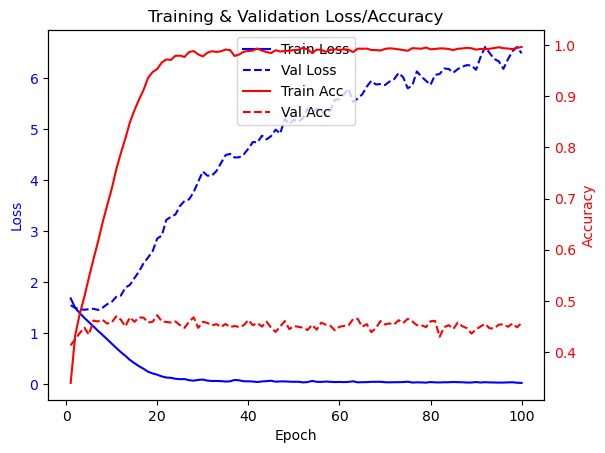

In [10]:
import matplotlib.pyplot as plt

# Extract values from the History object
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc  = history.history.get('accuracy', history.history.get('acc'))
val_acc    = history.history.get('val_accuracy', history.history.get('val_acc'))

#print final loss and accuracy
final_train_acc = train_acc[-1]
final_val_acc   = val_acc[-1]
print(f"Final training accuracy:   {final_train_acc*100:.2f}%")
print(f"Final validation accuracy: {final_val_acc*100:.2f}%")

#Plot beginning
fig, ax1 = plt.subplots()

#loss axis
ax1.plot(epochs, train_loss, 'b-', label='Train Loss')
ax1.plot(epochs, val_loss,   'b--', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

#accuracy axis
ax2 = ax1.twinx()
ax2.plot(epochs, train_acc, 'r-', label='Train Acc')
ax2.plot(epochs, val_acc,   'r--', label='Val Acc')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')

#legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

plt.title('Training & Validation Loss/Accuracy')
plt.show()


Final training accuracy:   98.07%
Final validation accuracy: 44.62%


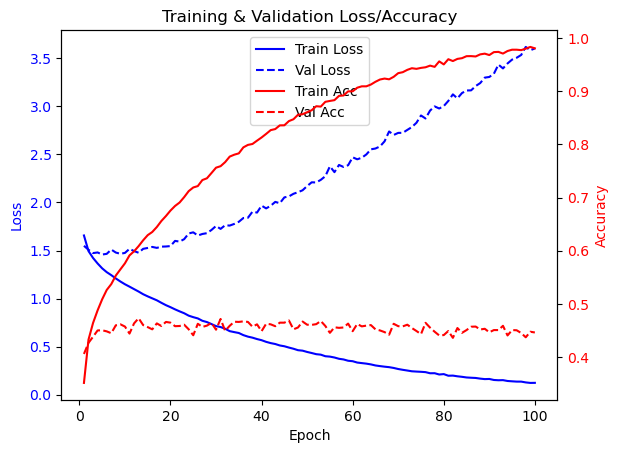

In [11]:
#Now do the same for the basic model
import matplotlib.pyplot as plt


epochs = range(1, len(history.history['loss']) + 1)
train_loss = history_basic.history['loss']
val_loss   = history_basic.history['val_loss']
train_acc  = history_basic.history.get('accuracy', history_basic.history.get('acc'))
val_acc    = history_basic.history.get('val_accuracy', history_basic.history.get('val_acc'))


final_train_acc = train_acc[-1]
final_val_acc   = val_acc[-1]
print(f"Final training accuracy:   {final_train_acc*100:.2f}%")
print(f"Final validation accuracy: {final_val_acc*100:.2f}%")


fig, ax1 = plt.subplots()


ax1.plot(epochs, train_loss, 'b-', label='Train Loss')
ax1.plot(epochs, val_loss,   'b--', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')


ax2 = ax1.twinx()
ax2.plot(epochs, train_acc, 'r-', label='Train Acc')
ax2.plot(epochs, val_acc,   'r--', label='Val Acc')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

plt.title('Training & Validation Loss/Accuracy')
plt.show()